# [Building Makemore Part 2: MLP](https://youtu.be/TCH_1BHY58I?si=0XlxK-C-_ccdzBJq)
Manu, 12/5  
Video is walking through [this code](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb) for makemore

## Makemore

Conitnuing makemore model
* last time used bigrams(one character predicts a next one with a lookup table of counts)
* we looked at only single previous character and predicted the distribution of next character in sequence
* we looked at counts of characters and normalized them into probabilities for the distribution
* problem is that predicitions are not good

Problems:
* one single character at a time is not enough context to create meaningful words, we have 27 possibilities 
* when we have 2 chars it becomes 27 x 27 possibilities and it scales as thus as we add more chars
* our matrix blows up to enourmous amounts and is not very hard to caculate

## MLP
Stands for **M**ulti **L**ayer **P**erceptron model

### [Bengio et al. 2003](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbVE5RlR3TkJRV3h6UTFsbk1VZERSNWQ5aXRiZ3xBQ3Jtc0trWm8tQXBiZHZuNmNNRzd1MHd0ZERIUkFzZWk0cWRHbFJ2VHNMdzVDYkhXOUQzSDJBYkNDSGZBbTY1RGllejZySmNfSGVsZ0xPQk5mQlRRX0xUcFJSRXZNNWFDanNhOUFERUYydDJxTmNRemtmcVNIVQ&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I)
The model we create follows [this](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbVE5RlR3TkJRV3h6UTFsbk1VZERSNWQ5aXRiZ3xBQ3Jtc0trWm8tQXBiZHZuNmNNRzd1MHd0ZERIUkFzZWk0cWRHbFJ2VHNMdzVDYkhXOUQzSDJBYkNDSGZBbTY1RGllejZySmNfSGVsZ0xPQk5mQlRRX0xUcFJSRXZNNWFDanNhOUFERUYydDJxTmNRemtmcVNIVQ&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I) paper.    

#### Important Note: 
Bergio et al. work with word level language models whereas Karpathy's implementation is a character level model. We can use this approach nonetheless just beware of the difference between our implementation and this paper. I might refer to words as I talk about the paper but characters will be used in our code.

#### Proposed Approach:
1. associate each word in the vocabulary a distributed *word feature vector* (a real valued vector in R^m)

2. express the joint *propbability function* of word sequences in terms of the feature vectors of these words in the sequence, and

3. learn simultaneously the *word feature vectors* and the parameters of that *probability function*

##### What does this mean?
Basically imagine we have a list of 17,000 words(check [note](#important-note) above) and for each word associate a 30 dimensional feature vector. Each word is embedded in a 30 dimensional space. 30 here cooresponds to m in the first note above. It could be 30, 60, or 100, they test through multiple different numbers. These words are tuned using backprop and move around the space. Words with similar meanings will end up in similar parts of the space and opposite for different words. 

##### Practical example
Suppose you had the phrase: 

    A dog was running in a  

And you wanted to predict what came at the end but you didn't have this exact phrase within your training set. You would be out of distribution and no reason to suspect what would come next. Maybe you have seen similar phrases such as: 

    *The* dog was running in a

Maybe our network has learned that *a* and *the* are similar and interchangeable. Thus the network has placed *a* and *the* close to each other within the space of their embeddings. A similar idea is with *cat* and *dog*. We can then apply these similar findings to genrealise to novel scenarios. Say we had the following phrase in our training data: 

    The cat was walking in the bedroom

We could infer the full sentence from before could be:  

    A dog was running in a room

Our network might have learned that *a* and *the* are interchangeable as well as *cat* and *dog*, *running* and *walking*, and *room* and *bedroom*. Therefore we can infer the end of the sentence.

#### Neural Network Diagram
The neural network diagram below is an example of the MLP model we will implement.
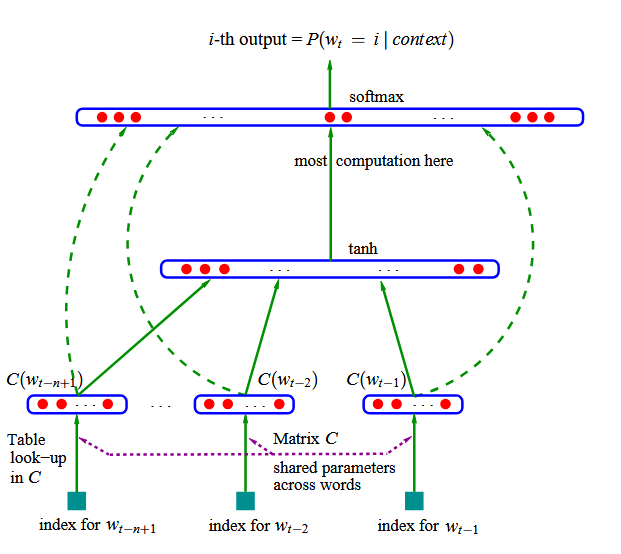

Let's break this diagram up into the three layers.

##### Layer One
In this example we are taking three previous words an attempting to predict the fourth word in the sequence. The three previous words are represented by their indexes within a look up table C as the green boxes at the bottom of the diagram and the output at the top will be used to give the fourth word. If we use our example from before where we have 17,000 words then the index will be an integer 0-16,999 and we are indexing into a matrix C that is 17,000 by say 30(could be 50, 100 see [above](#what-does-this-mean)). Every index is plucking out a row from the lookup table and getting that 30 dimensional embdedding vector for that word.

##### Layer Two
Next is the hidden layer, tanh. It is a hyperparameter that can be as large or small as you like. Say there were 100 neurons in this layer, they would be connected to all of the 90 dimensions that make up the three words from before. 

##### Layer Three
Then the final layer is a softmax layer that contains all the possiblities of the 17,000 words that could come next. Thus it is a 17,000 logit layer that is connected to each of the 100 neurons from the hidden layer. This softmax layer is normalized and adds up to 1 that is therefore a probability distribution of the next word to come in the sequence. 

## Code Implementation
Let's begin the code implementation of the proposed setup and model described above.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [2]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# compile dataset for nn

block_size = 3 # context length: how many characters do we take to predict the next one?
# refer back to the neural network diagram. That diagram used 3 words to predict the next word

X, Y = [], [] # X is the input to the neural net, and Y is the labels for each example inside X
for w in words[:5]: # going over first 5 names for now but will eventually go over full training set

    print(w) # the name 
    context = [0] * block_size # padded context of zero tokens
    for ch in w + '.': # go over every character in the sequence of the name
        ix = stoi[ch] # get the character's corresponding integer from the mapping we made before
        X.append(context) # stores the current running context for this character
        Y.append(ix) # build out array Y for this current character
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop the context and append the new context to the sequence

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype